<a href="https://colab.research.google.com/github/Untick/IrisID_gr1/blob/Daria-Petrova-folder/Petrova%20Daria/%20Iris_ID_7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Импорт:

# Модуля для поиска файлов по заданному шаблону пути
import glob

# Класса модели Sequential из библиотеки Keras для создания модели НС прямого распространения
from tensorflow.keras.models import Sequential 

# Классов слоёв для построения свёрточных нейронных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Класса для генерации аугментированных изображений из файлов изображений и их меток
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Класса оптимизатора Adam для обновления параметров модели в процессе обучения
from tensorflow.keras.optimizers import Adam     

# Утилиты для работы с моделями для преобразования меток классов и кодирования One-Hot
from tensorflow.keras import utils               

# Модуля для работы с предобработкой изображений (загрузка, изменение размера, преобразование в массивы, отрисовка изображений и т.д.)
from tensorflow.keras.preprocessing import image 

# Класса обратного вызова, позволяющего сохранять лучшие веса модели в процессе обучения
from tensorflow.keras.callbacks import ModelCheckpoint

# Модуля для вычисления различных метрик оценки модели, таких как матрица ошибок классификатора (confusion matrix)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Функции для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

# Библиотеки для работы с многомерными массивами и математическими операциями
import numpy as np

# Модуля для создания графиков и визуализации данных
import matplotlib.pyplot as plt                  

# Классов для работы с изображениями, таких как загрузка, улучшение и другие операции
from PIL import Image, ImageEnhance                       

# Модуля для работы с случайными числами, выборками и операциями 
import random                                    

# Модуля для математических операций
import math                                      

# Модуля для взаимодействия с операционной системой, такой как создание, удаление и перемещение файлов и папок 
import os

# Модуля для выполнения операций с файлами и папками, такие как копирование и удаление
import shutil

# Модуля для работы с ZIP-архивами
import zipfile     

# Модуля для работы со временем и измерения производительности
import time                                   

# Библиотеки для создания и обучения нейронных сетей
import tensorflow as tf

# Модуля для управления памятью и сборщиком мусора
import gc

# Модуля для загрузки файлов из Google Drive
import gdown

# Библиотеки OpenCV для обработки изображений и видео
import cv2

# Модуля SciPy для работы с многомерными массивами и операциями над ними
from scipy import ndimage

# Модулей для работы с изображениями и доступом к Google Drive в среде Google Colab
from google.colab.patches import cv2_imshow
from google.colab import drive

In [ ]:
#@title Подключение к диску
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Импортирование папки с датасетами из Google Drive в директорию Google Colab.
# Путь к папке на Google Drive, в которую будут загружаться новые данные
drive_folder_path = '/content/drive/MyDrive/IrisID'

# Путь к папке в директории Google Colab
colab_folder_path = '/content/IrisID'

if not os.path.exists(colab_folder_path):
    # Копирование файлов из Google Drive в Google Colab
    os.makedirs(colab_folder_path)
    
    # Копирование файлов из Google Drive в Google Colab
for file_name in os.listdir(drive_folder_path):
    src = os.path.join(drive_folder_path, file_name)
    dst = os.path.join(colab_folder_path, file_name)
    shutil.copy(src, dst)

else:
    print("Папка IrisID уже существует в директории Google Colab.")

In [ ]:
#@title Проверка наличия новых архивов в папке IrisID в директории Google Colab.
archives = [f for f in os.listdir(drive_folder_path) if f.endswith('.zip')]

if len(archives) == 0:
    print("Архивы отсутствуют в папке IrisID на Google Drive.")
else:
    print("Найдены следующие архивы в папке IrisID на Google Drive:")
    print('\n'.join(archives))

# Путь к файлу, в котором будет храниться список предыдущих архивов
# (с момента последнего пополенения папки IrisID на Google Drive)
previous_archives_file = '/content/previous_archives.txt'

# Проверка наличия предыдущего списка архивов
if os.path.exists(previous_archives_file):
    # Загрузка предыдущего списка архивов
    with open(previous_archives_file, 'r') as file:
        previous_archives = file.read().splitlines()
else:
    previous_archives = []

# Проверка наличия новых архивов и отображение их в виде списка
new_archives = [archive for archive in archives if archive not in previous_archives]

print("Среди них новых архивов:", end=" ")
if len(new_archives) == 0:
    print("нет.")
else:
    print(f"{len(new_archives)}")
    print('\n'.join(new_archives))

# Объединение текущего списка архивов с предыдущими
updated_archives = previous_archives + archives

# Сохранение обновлённого списка архивов
with open(previous_archives_file, 'w') as file:
    file.write('\n'.join(updated_archives))

In [ ]:
#@title Распаковка новых архивов и сортировка изображений по папкам классов.

def extract_archives():
    # Пути к папкам
    ids_path = os.path.join(colab_folder_path, 'IDs')

    # Распаковка архивов
    archives = glob.glob(os.path.join(colab_folder_path, '*.zip'))
    for archive in archives:
        archive_name = os.path.splitext(os.path.basename(archive))[0]
        extraction_path = os.path.join(ids_path, archive_name)

        # Проверка наличия папки с именем архива внутри папки IDs
        if not os.path.exists(extraction_path):
            with zipfile.ZipFile(archive, 'r') as zip_ref:
                # Получение списка файлов в архиве
                file_list = zip_ref.namelist()

                # Проверка наличия основной директории в архиве
                has_main_directory = False
                for file in file_list:
                    if '/' in file:
                        has_main_directory = True
                        break

                # Если основная директория отсутствует, создаём папку с названием архива внутри IDs
                if not has_main_directory:
                    extraction_path = os.path.join(ids_path, archive_name)
                    os.makedirs(extraction_path)

                # Извлечение файлов
                zip_ref.extractall(extraction_path)
            os.remove(archive)
        else:
            print(f"Архив {archive_name} уже распакован.")
            os.remove(archive)
            
extract_archives()

In [ ]:
#@title Пути к папкам с пациентами
ids_path = '/content/IrisID/IDs'
train_path = '/content/IrisID/train'
test_path = '/content/IrisID/test'
val_path = '/content/IrisID/val'

In [ ]:
#@title Разделение датасетов на train, test и val выборки.

def create_train_test_val_split():

    # Создание папок train, test и val, если они не существуют
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    if not os.path.exists(val_path):
        os.makedirs(val_path)

    # Очистка содержимого папок train, test и val

    def clear_directory(directory_path):
        for filename in os.listdir(directory_path):
            file_path = os.path.join(directory_path, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)

    # Очистка содержимого папок train, test и val
    clear_directory(train_path)
    clear_directory(test_path)
    clear_directory(val_path)

    # Получение списка всех папок внутри IDs
    folders = [folder for folder in os.listdir(ids_path) if os.path.isdir(os.path.join(ids_path, folder))]

    for folder in folders:
        folder_path = os.path.join(ids_path, folder)
        files = os.listdir(folder_path)

        # Перемешивание списка файлов
        random.shuffle(files)

        # Определение количества файлов для тренировочной, тестовой и валидационной выборок (60% для тренировки, 20% для теста, 20% для валидации)
        train_split_index = int(0.6 * len(files))
        test_split_index = int(0.8 * len(files))
        train_files = files[:train_split_index]
        test_files = files[train_split_index:test_split_index]
        val_files = files[test_split_index:]

        # Создание подпапок для каждого класса внутри папок train, test и val
        train_class_path = os.path.join(train_path, folder.replace("iris", "", 1))
        test_class_path = os.path.join(test_path, folder.replace("iris", "", 1))
        val_class_path = os.path.join(val_path, folder.replace("iris", "", 1))

        if not os.path.exists(train_class_path):
            os.makedirs(train_class_path)
        if not os.path.exists(test_class_path):
            os.makedirs(test_class_path)
        if not os.path.exists(val_class_path):
            os.makedirs(val_class_path)

        # Перемещение файлов в папки train, test и val с правильными метками
        for file in train_files:
            src = os.path.join(folder_path, file)
            dst = os.path.join(train_class_path, file.replace("iris", "", 1))
            shutil.copy(src, dst)

        for file in test_files:
            src = os.path.join(folder_path, file)
            dst = os.path.join(test_class_path, file.replace("iris", "", 1))
            shutil.copy(src, dst)

        for file in val_files:
            src = os.path.join(folder_path, file)
            dst = os.path.join(val_class_path, file.replace("iris", "", 1))
            shutil.copy(src, dst)

# Вызов функции для создания тренировочной, тестовой и валидационной выборок
create_train_test_val_split()

In [ ]:
#@title Параметры аугментации (матаданные).

augmentation_params = {
    'flipped': True,
    'brightness': 1.2,
    'contrast': 0.8,
    'scale_factor': 1.1,
    'rotation_angle': 5,
    'translation_x': 10,
    'translation_y': -5,
    'shear_angle': -3,
    'add_noise': True,
    'crop_x': 20,
    'crop_y': 10
}

In [ ]:
#@title Первичная аугментация с использованием OpenCV и метаданных.

def augment_images(train_path, augmentation_params):
    # Получение списка файлов в папке
    files = os.listdir(train_path)

    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            # Полный путь к файлу
            file_path = os.path.join(train_path, file)

            # Загрузка изображения
            image = cv2.imread(file_path)

            # Горизонтальное отражение
            if augmentation_params.get('flipped', False):
                flipped = cv2.flip(image, 1)
                flipped_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
                flipped_file_path = os.path.join(train_path, flipped_file)
                cv2.imwrite(flipped_file_path, flipped)

            # Изменение яркости и контраста
            brightness = augmentation_params.get('brightness', 1.0)
            contrast = augmentation_params.get('contrast', 1.0)
            adjusted = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
            adjusted_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
            adjusted_file_path = os.path.join(train_path, adjusted_file)
            cv2.imwrite(adjusted_file_path, adjusted)

            # Изменение размера и масштабирование
            scale_factor = augmentation_params.get('scale_factor', 1.0)
            resized = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
            resized_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
            resized_file_path = os.path.join(train_path, resized_file)
            cv2.imwrite(resized_file_path, resized)

            # Аффинные преобразования
            rows, cols, _ = image.shape
            rotation_angle = augmentation_params.get('rotation_angle', 0)
            translation_x = augmentation_params.get('translation_x', 0)
            translation_y = augmentation_params.get('translation_y', 0)
            shear_angle = augmentation_params.get('shear_angle', 0)

            M = cv2.getRotationMatrix2D((cols // 2, rows // 2), rotation_angle, 1)
            M[:, 2] += (translation_x, translation_y)
            M[0, 1] += shear_angle * 0.1

            transformed = cv2.warpAffine(image, M, (cols, rows))
            transformed_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
            transformed_file_path = os.path.join(train_path, transformed_file)
            cv2.imwrite(transformed_file_path, transformed)

            # Добавление шума
            if augmentation_params.get('add_noise', False):
                noise = np.random.normal(loc=0, scale=10, size=image.shape).astype(np.uint8)
                noisy = cv2.add(image, noise)
                noisy_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
                noisy_file_path = os.path.join(train_path, noisy_file)
                cv2.imwrite(noisy_file_path, noisy)

            # Кропы и рандомизация позиции
            crop_x = augmentation_params.get('crop_x', 0)
            crop_y = augmentation_params.get('crop_y', 0)
            cropped = image[crop_y:rows - crop_y, crop_x:cols - crop_x]
            cropped_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
            cropped_file_path = os.path.join(train_path, cropped_file)
            cv2.imwrite(cropped_file_path, cropped)

# Получение списка классов
classes = [folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))]

for class_name in classes:
    class_train_path = os.path.join(train_path, class_name)
    
    # Вызов функции аугментации для папки "train" каждого класса
    augment_images(class_train_path, augmentation_params)

# Вызов функции аугментации для папки "train"
augment_images(train_path, augmentation_params)

**Демонстрация случайного изображения из выборки train.**

Этот код выбирает случайное изображение из папки train и отображает его с помощью библиотеки matplotlib.

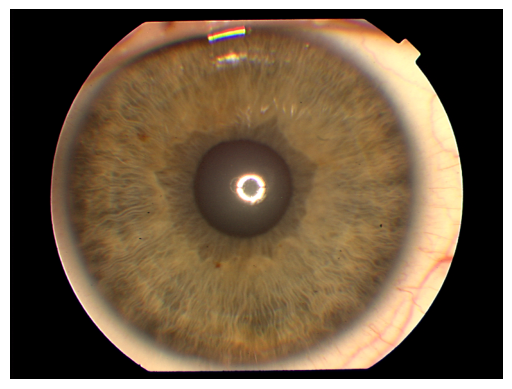

In [ ]:
def display_random_image(train_path):
    # Получение списка всех файлов в папке train
    files = os.listdir(train_path)

    # Случайный выбор изображения
    random_file = random.choice(files)
    image_path = os.path.join(train_path, random_file)

    # Загрузка и отображение изображения
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Вызов функции для отображения случайного изображения
display_random_image(train_path)

# Всё содержимое папки IrisID можно очистить, если была допущена какая-либо ошибка...

In [ ]:
#@title Функция для полной очистки папки IDs от содержимого.

def clear_ids_folder():
    
    # Удаление содержимого папки IDs
    shutil.rmtree(colab_folder_path)
    
    # Пересоздание пустой папки IDs
    os.makedirs(colab_folder_path)

# Вызов функции для очистки папки IrisID
clear_ids_folder()

... И проделать этапы I-II заново.

In [ ]:
#@title Определение размеров классов и общий размер базы данных.

# Определение списка имен классов
class_list = sorted(os.listdir(train_path))

# Определение количества классов
class_count = len(class_list)

# Вывод результатов
print(f'Количество классов: {class_count}, метки классов: {class_list}')

for class_name in class_list:
    train_class_path = os.path.join(train_path, class_name)
    val_class_path = os.path.join(val_path, class_name)
    test_class_path = os.path.join(test_path, class_name)

    train_class_files = os.listdir(train_class_path)
    val_class_files = os.listdir(val_class_path)
    test_class_files = os.listdir(test_class_path)

    train_file_count = len(train_class_files)
    val_file_count = len(val_class_files)
    test_file_count = len(test_class_files)

    # Размеры класса и общего набора
    print(f'Размер класса {class_name}: {train_file_count} пациентов, для валидации выделено файлов: {val_file_count}, для теста выделено файлов: {test_file_count}')

# Общий размер базы
train_count = sum([len(files) for _, _, files in os.walk(train_path)])
val_count = sum([len(files) for _, _, files in os.walk(val_path)])
test_count = sum([len(files) for _, _, files in os.walk(test_path)])

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - val_count - test_count}, для валидации: {val_count}, для теста: {test_count}')

Количество классов: 3, метки классов: ['17_24', '1_8', '9_16']
Размер класса 17_24: 28 пациентов, для валидации выделено файлов: 10, для теста выделено файлов: 10
Размер класса 1_8: 28 пациентов, для валидации выделено файлов: 10, для теста выделено файлов: 10
Размер класса 9_16: 28 пациентов, для валидации выделено файлов: 10, для теста выделено файлов: 10
Общий размер базы: 84, выделено для обучения: 24, для валидации: 30, для теста: 30


In [ ]:
#@title Параметры аугментации.

TEST_SPLIT          = 0.2                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 230                   # Ширина изображения для нейросети
IMG_HEIGHT          = 60                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Gray равно 1)

ROTATION_RANGE      = 2                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 10                    # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 10                    # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.08                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.8, 1.2)            # Пределы изменения яркости
HORIZONTAL_FLIP     = False                 # Горизонтальное отражение разрешено

EPOCHS              = 350                   # Число эпох обучения
BATCH_SIZE          = 32                    # Размер батча для обучения модели
OPTIMIZER           = Adam(0.00001)         # Оптимизатор

In [ ]:
#@title Автоматизированная аугментация с использованием генератора IDG.

# Создание объекта ImageDataGenerator для аугментации изображений
# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам

# Создание объектов ImageDataGenerator для аугментации и нормализации
train_datagen = ImageDataGenerator(
    rescale=1. / 255.,
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    zoom_range=ZOOM_RANGE,
    brightness_range=BRIGHTNESS_RANGE,
    horizontal_flip=HORIZONTAL_FLIP
)

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
    rescale=1. / 255.
)

# Создание генераторов изображений для обучающего, валидационного и тестового наборов данных
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 84 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [ ]:
#@title Проверка формы данных и назначения меток классов.

# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (32, 60, 230, 3), (32, 3), батчей: 3
Формы данных   проверочной выборки: (30, 60, 230, 3), (30, 3), батчей: 1
Формы данных      тестовой выборки: (30, 60, 230, 3), (30, 3), батчей: 1

Метки классов тренировочной выборки: {'17_24': 0, '1_8': 1, '9_16': 2}
Метки классов   проверочной выборки: {'17_24': 0, '1_8': 1, '9_16': 2}
Метки классов      тестовой выборки: {'17_24': 0, '1_8': 1, '9_16': 2}


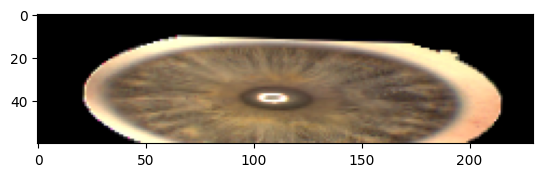

In [ ]:
#@title Проверка работы аугментатора на примере любого изображения из выборки.

# Получение случайного индекса батча
random_batch_index = random.choice(range(len(train_generator)))

# Получение случайного батча
batch_images, batch_labels = train_generator[random_batch_index]

# Получение случайного индекса изображения в батче
random_image_index = random.choice(range(len(batch_images)))

# Получение случайного изображения и его метки
image = batch_images[random_image_index]
label = batch_labels[random_image_index]

# Отображение изображения
plt.imshow(image)
plt.show()

In [ ]:
#@title Функция рисования образцов изображений из заданной выборки.

def show_batch(batch,                # батч с примерами
               img_range=range(8),  # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(class_list[class_label])
        ax[ix].imshow(batch[0][i])  
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

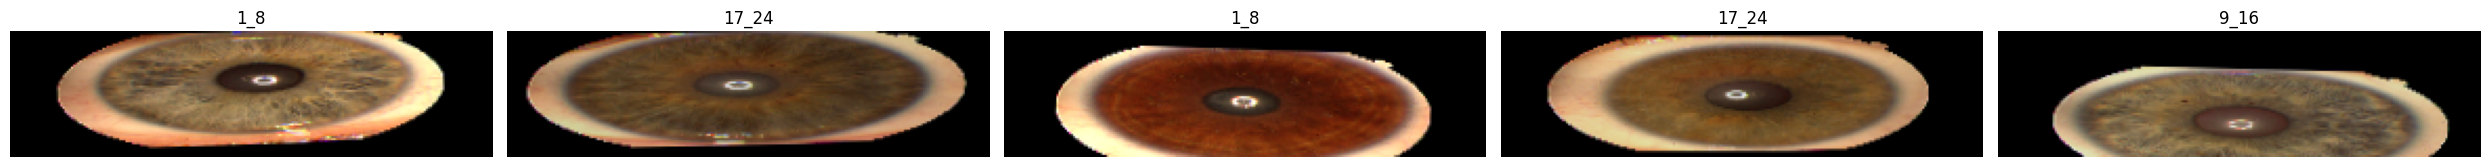

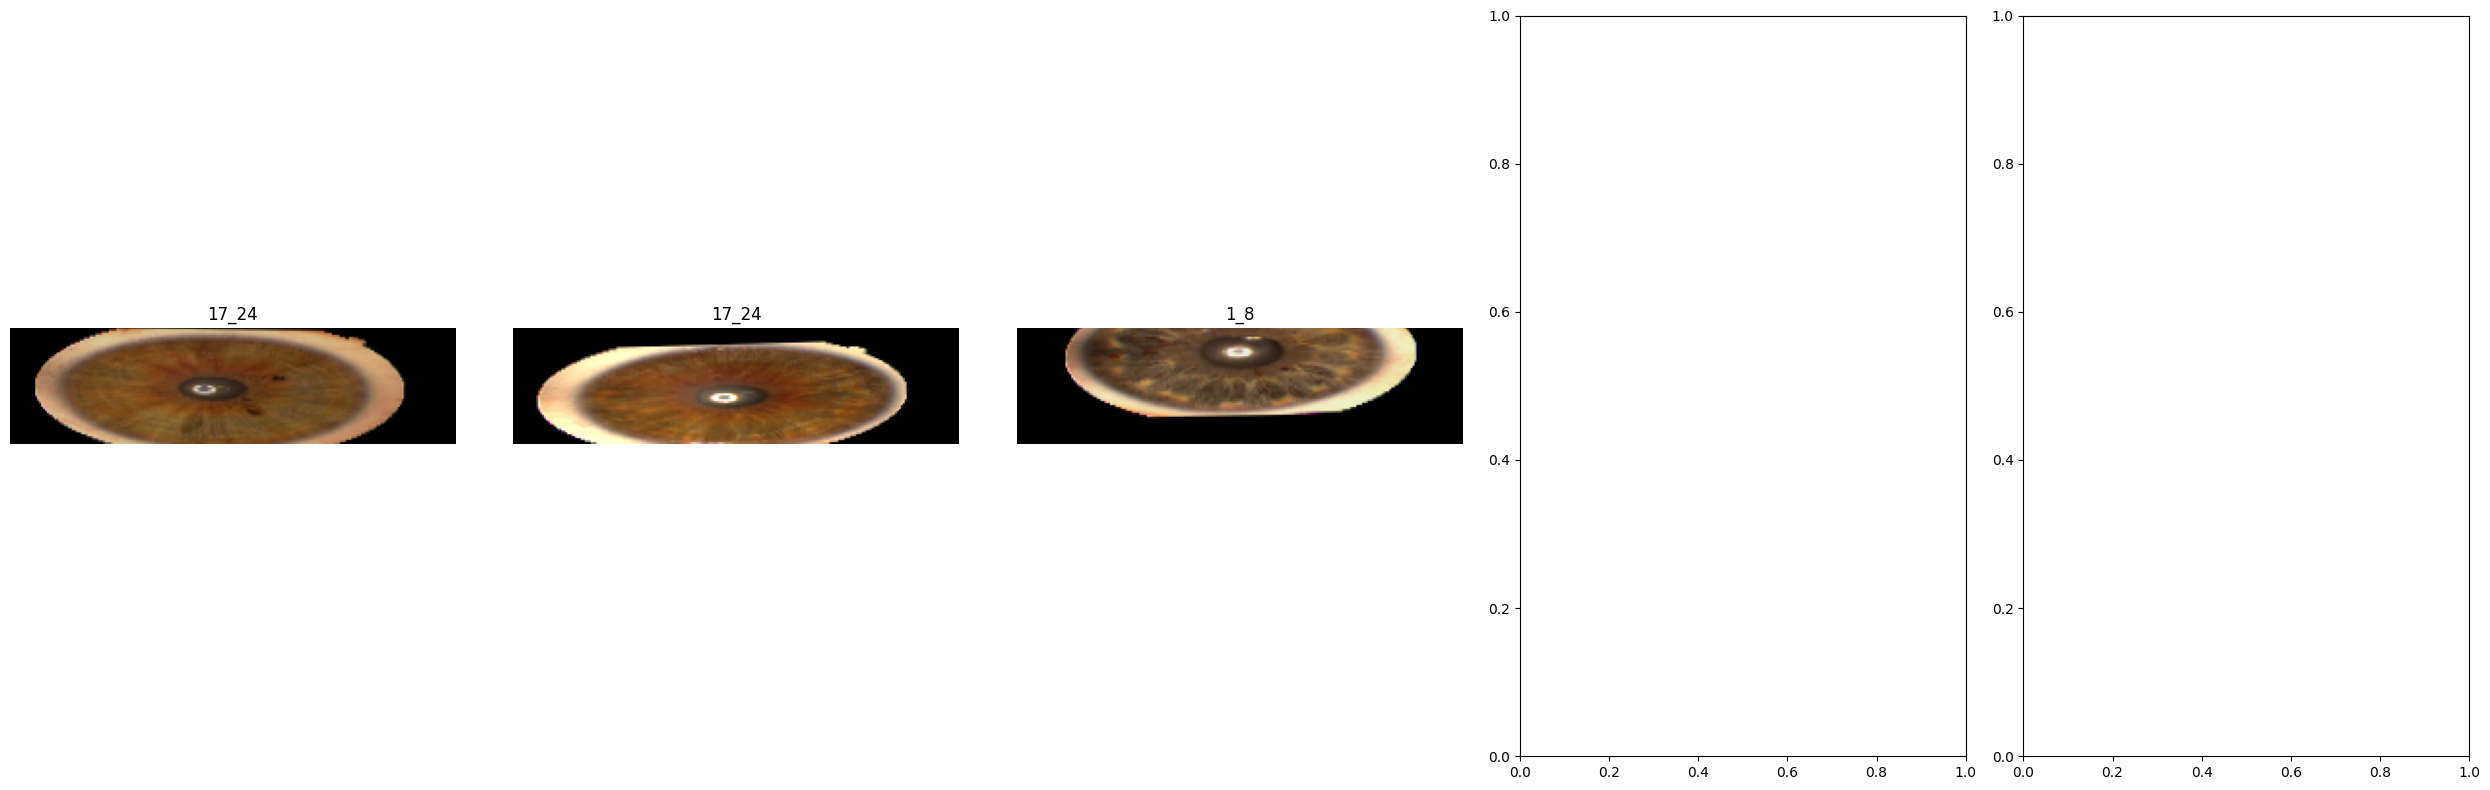

In [ ]:
#@title Вывод примеров из 0-го батча train_generator.
show_batch(train_generator[0])

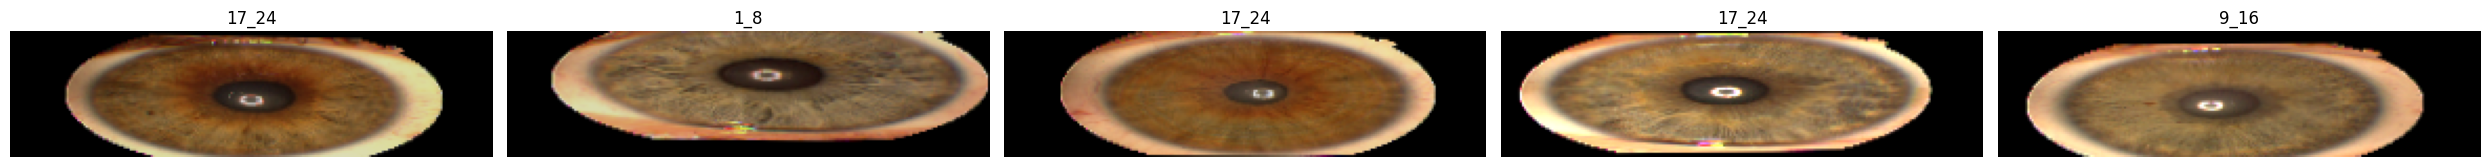

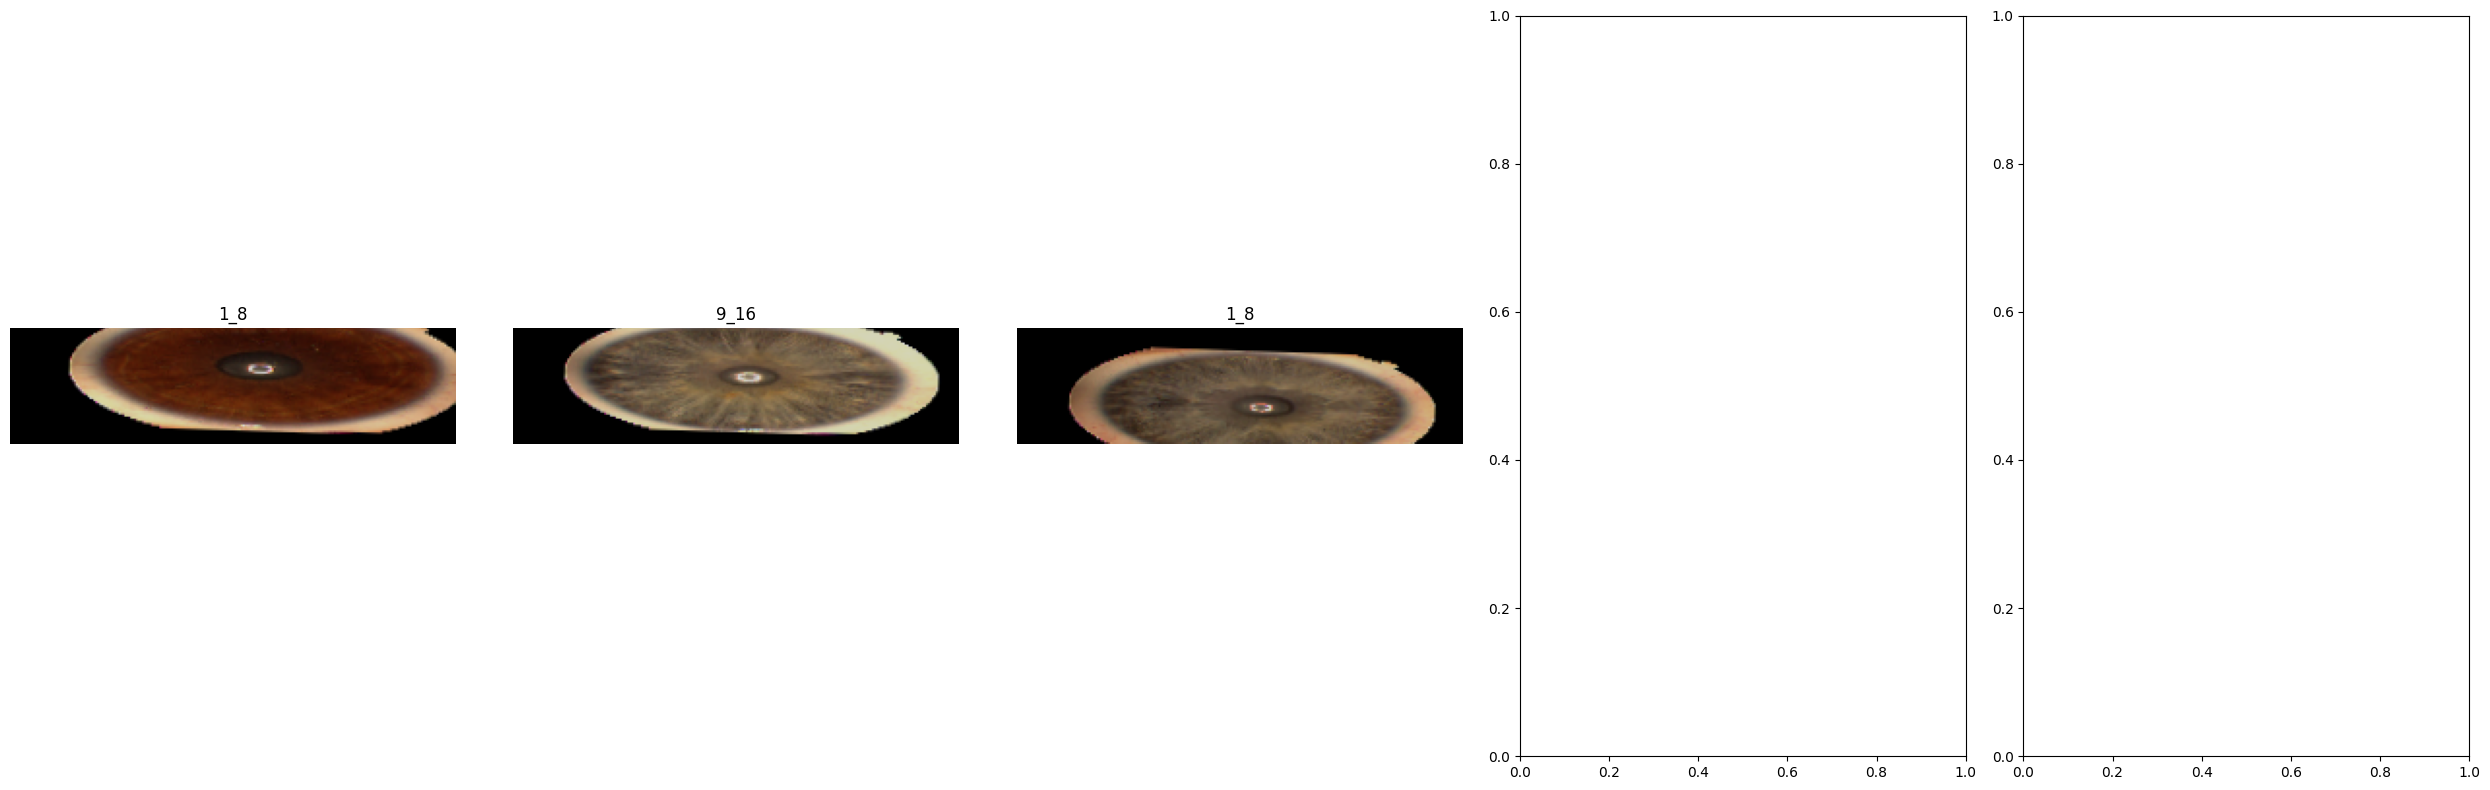

In [ ]:
#@title Вывод примеров из 0-го батча validation_generator.
show_batch(validation_generator[0])

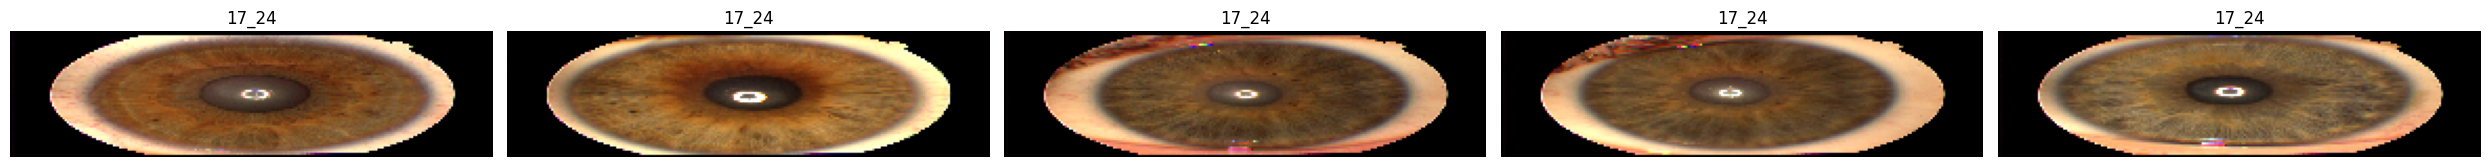

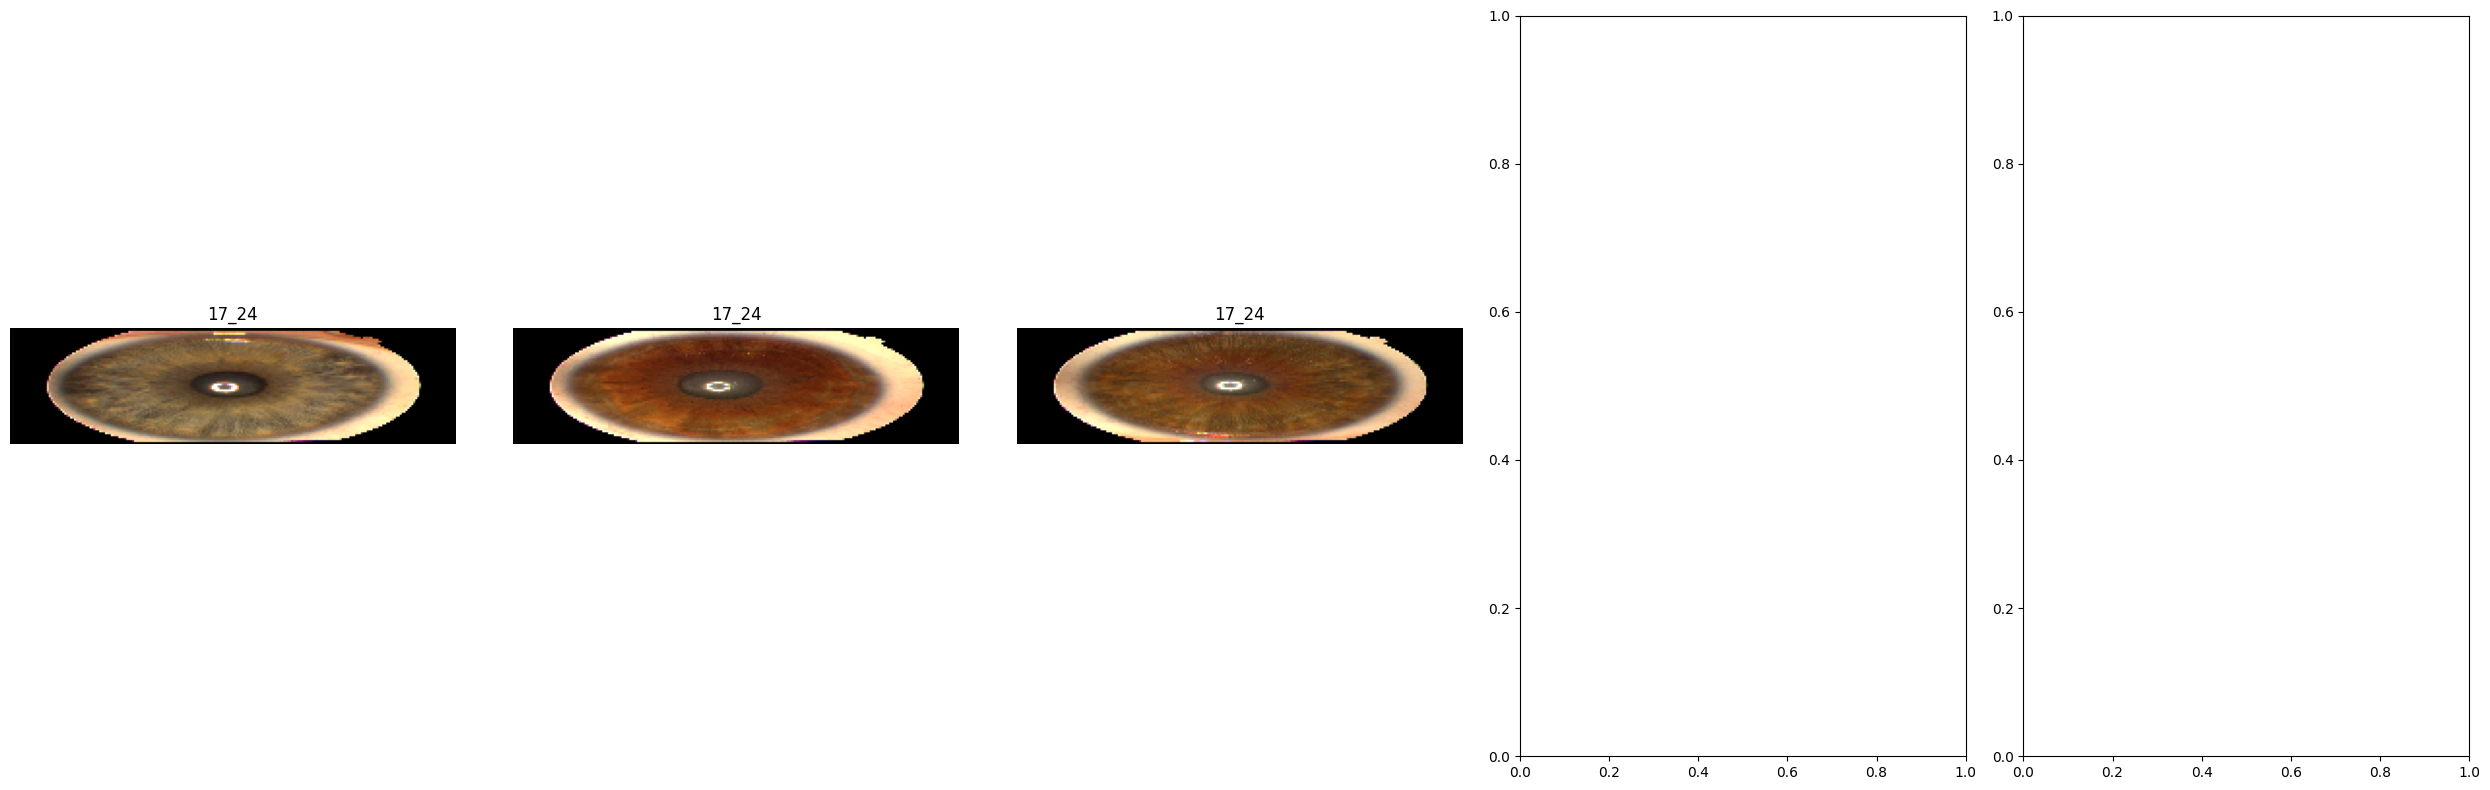

In [ ]:
#@title Вывод примеров из 0-го батча validation_generator.
show_batch(test_generator[0])

In [ ]:
#@title Функция компиляции и обучения модели нейронной сети.

# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [ ]:
#@title Функция вывода результатов оценки модели на заданных данных.

def eval_model(model, 
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
#@title Совместная функция обучения и оценки модели нейронной сети.

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=class_list,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model, 
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1], 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)

In [ ]:
#@title Архитектура модели.

# Создание последовательной модели
model_conv = Sequential()

# Первый сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model_conv.add(BatchNormalization())

# Второй сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))

# Третий сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Dropout(0.2))

# Четвертый сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.2))

# Пятый сверточный слой
model_conv.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())

# Шестой сверточный слой
model_conv.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.2))

# Слой преобразования многомерных данных в одномерные 
model_conv.add(Flatten())

# Промежуточный полносвязный слой
model_conv.add(Dense(2048, activation='relu'))

# Промежуточный полносвязный слой
model_conv.add(Dense(4096, activation='relu'))

# Выходной полносвязный слой с количеством нейронов по количесту классов
model_conv.add(Dense(class_count, activation='softmax')) 

In [ ]:
#@title Обучение модели и вывод оценки ее работы на тестовых данных.
compile_train_eval_model(model_conv,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=class_list,
                         title='Сверточный классификатор')

model_conv.save('/content/drive/MyDrive/IrisID/model_v1.h5')

In [ ]:
#@title Дообучение модели и вывод оценки её работы на тестовых данных.
compile_train_eval_model(model_conv,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=class_list,
                         title='Сверточный классификатор')

model_conv.save('/content/drive/MyDrive/IrisID/model_v1.h5')

## Оценка производительности модели.

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
#@title Вывод результатов оценки работы модели на тестовых данных.

try:
    eval_model(model, test_generator[0][0], test_generator[0][1],
               class_labels=class_list, 
               title=f'Сверточный классификатор на {len(class_list)} классах')
except Exception as e:
    print('Произошла ошибка:', e)

In [ ]:
#@title Загрузка лучшей модели
model = load_best_model('/content/gdrive/MyDrive/IrisID/best_model.h5')